# Experiment with the MNIST data set

In [1]:
from aitk.utils import gallery, array_to_image
from aitk.networks import Network

import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical

2022-10-28 14:26:48.955227: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Get the data
* Download the data
* Explore what you have

In [2]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
train_x.shape

(60000, 28, 28)

In [4]:
test_x.shape

(10000, 28, 28)

In [5]:
images = [array_to_image(train_x[i]) for i in range(20)]

In [6]:
gallery(images)

0,1,2,3,4
5,6,7,8,9
10,11,12,13,14
15,16,17,18,19


In [7]:
train_y[:20]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
      dtype=uint8)

# Prepare the data for the network
* You may need to normalize the inputs so that they are in the range [0,1].
* You may need to convert the targets so that they are represented as one-hot vectors when you are doing categorization.

###  Normalizing the input data

Start by finding the minimum value and the maximum value within your data set.

In [7]:
min_input = train_x.min()
max_input = train_x.max()
print("range of input values is:", min_input, max_input)

range of input values is: 0 255


The formula for normalizing your data is:

`(data - min_input)/(max_input - min_input)`

For most image data the min_input is 0 and the max_input is 255, as is the case here.  This simplifies the equation to:

`data/255`


In [8]:
train_x_normalized = train_x/255

In [9]:
test_x_normalized = test_x/255

### Data sent into a Conv2D layer must have a depth
* This may require you to do a reshape command.
* For these black and white images there is only one channel of information.
* For color images there are typically 3 channels (Red, Green, Blue)

In [10]:
train_x_normalized = train_x_normalized.reshape(60000,28,28,1)
test_x_normalized = test_x_normalized.reshape(10000,28,28,1)

### Target data

When doing a classification task we would typically convert the output into one-hot vectors. For some data sets you may not know how many classes there are.  You can put the training data into a set to find out how many unique classifications you have. 

In [11]:
num_categories = len(set(train_y))

Then you can use the number of categories to produce one-hot vectors using `to_categorical`.

In [12]:
train_y_category = to_categorical(train_y, num_categories)

In [13]:
test_y_category = to_categorical(test_y, num_categories)

In [14]:
train_y_category[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

# Construct the model

This is just one possible configuration of layers to learn the MNIST data set.  Feel free to experiment with the number of filters, the filter size, and the layers themselves.

NOTE: In the final layer we are using an activation function called **softmax**.  This will output a probability and is typically used in classification problems like the one we are trying to solve.  It is usually paired with the loss function called **categorical_crossentropy**.

In [15]:
neural_net = Sequential()
neural_net.add(Conv2D(8,(5,5),activation="relu",name="conv1",input_shape=(28,28,1)))
neural_net.add(MaxPooling2D(pool_size=(2,2),name="pool1"))
neural_net.add(Flatten(name="flatten"))
neural_net.add(Dense(100, activation='relu',name="hidden"))
neural_net.add(Dense(10, activation='softmax',name="output"))
neural_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 24, 24, 8)         208       
                                                                 
 pool1 (MaxPooling2D)        (None, 12, 12, 8)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 hidden (Dense)              (None, 100)               115300    
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 116,518
Trainable params: 116,518
Non-trainable params: 0
_________________________________________________________________


2022-10-28 14:49:34.769893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 14:49:34.913881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 14:49:34.914298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 14:49:34.916557: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

# Compile the model

For our XOR networks we defined loss as sum-squared error.  However, for categorical data like handwritten digits it is better to use a different loss function called *categorical_crossentropy*.  This interprets the outputs as representing probabilities and forces them to sum to 1.0.  Thus the output from the network will reflect how likely it considers a particular input to be a member of one of the output categories.

In [16]:
neural_net.compile(optimizer="adam", loss="categorical_crossentropy",
                   metrics=['accuracy'])

# Create an aitk Network
This allows us to do more visualization of what is happening inside the network.

In [17]:
net = Network(neural_net)

Each layer may create a different range of values.  Configure the layers to a typical range to ensure that the layers will be properly displayed.

In [18]:
net.set_config_layer("conv1", colormap=("gray", 0, 3))
net.set_config_layer("pool1", colormap=("gray", 0, 3))
net.set_config_layer("flatten",colormap=("gray", 0, 3))
net.set_config_layer("hidden", colormap=("gray", 0, 12))

The loop below shows you how the network performs on 10 sample images.  When you run this cell **prior** to training the output layer (at the top) has no clear winning categories before learning has occurred. However, if you re-run this cell **after** training you'll see that the network has correctly learned the classification for almost all of the images.

In [19]:
from time import sleep

In [20]:
for i in range(10,20):
    net.propagate(test_x_normalized[i])
    net.display(test_x_normalized[i])
    sleep(1.0)

# Train the model

In [21]:
history = net.fit(train_x_normalized, 
                  train_y_category, 
                  verbose=1,
                  validation_data=(test_x_normalized, 
                                   test_y_category),
                  epochs=5)

Epoch 5/5 loss: 0.027292223647236824 - accuracy: 0.9914500117301941 - val_loss: 0.046102125197649 - val_accuracy: 0.9847000241279602


# Inspect the feature maps

We can ask the network to propagate to specific layers and inspect the representations created there to try to understand how it has solved the problem.

Using one test image, find out what the maximum value is so that you can set up the color map properly. If you see a large red box in one of the visualized channels below, then use the image number for that test image to correct the color map.

In [22]:
from math import ceil
for layer in ["conv1", "pool1"]:
    data = [net.propagate_to(test_x_normalized[49], layer, channel=channel)
            for channel in range(8)]
    largest = max([sublist.max() for sublist in data])
    net.set_config_layer(layer, colormap=("gray", 0, ceil(largest)))

Check out 10 different test images to see how each channel is representing them. Press the **enter** key to toggle thru the images.

channel0,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8

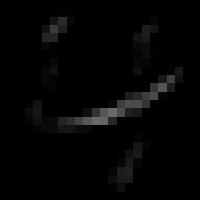
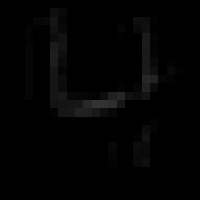
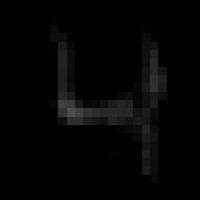
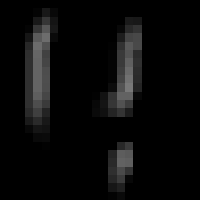
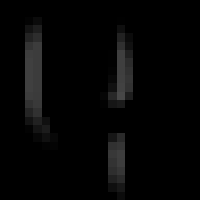
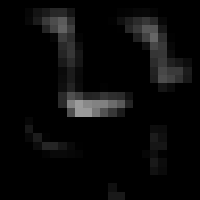
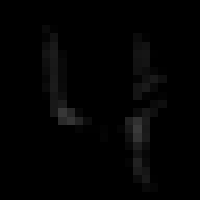
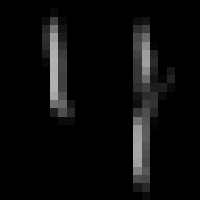

press enter 


In [25]:
for test_case in range(40,50):
    c_images = [net.propagate_to(test_x_normalized[test_case], "conv1", "image", channel=channel)
                for channel in range(8)]
    c_bigger = [image.resize((200,200),resample=0) for image in c_images]
    original = test_x_normalized[test_case]
    gallery([original] + c_bigger, labels="channel{index}", gallery_shape=(9,1))
    input("press enter")

channel0,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8

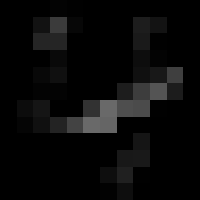
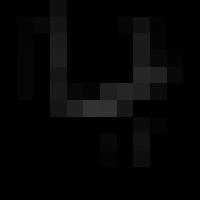
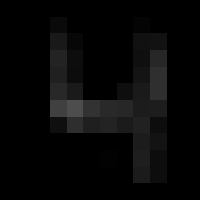
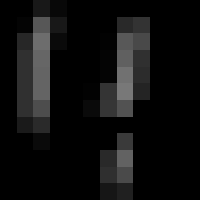
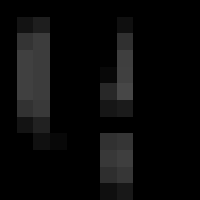
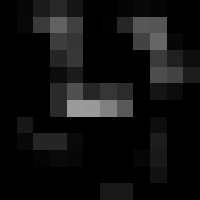
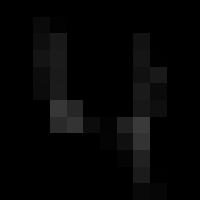
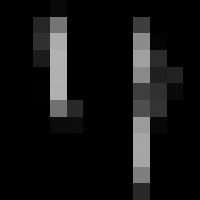

press enter 


In [26]:
for test_case in range(40,50):
    p_images = [net.propagate_to(test_x_normalized[test_case], "pool1", "image", channel=channel)
                for channel in range(8)]
    p_bigger = [image.resize((200,200),resample=0) for image in p_images]
    original = test_x_normalized[test_case]
    gallery([original] + p_bigger, labels="channel{index}", gallery_shape=(9,1))
    input("press enter")

# Examine the results
Check which inputs the network is getting wrong. Recall that there are 10 thousand test images.

In [27]:
from numpy import argmax
outputs = net.predict(test_x_normalized)
answers = [argmax(output) for output in outputs]
targets = [argmax(target) for target in test_y_category]

In [28]:
incorrect = [i for i in range(len(answers)) if answers[i] != targets[i]]
missed_target = [targets[i] for i in incorrect]
wrong_answer = [answers[i] for i in incorrect]
print("Number of incorrectly categorized images", len(missed_target))

Number of incorrectly categorized images 153


We can use the `Counter` class from the `collections` library to find out which target is most commonly missed and which wrong answer is mot commonly given.

In [29]:
from collections import Counter

In [30]:
t_ctr = Counter(missed_target)
t_ctr.most_common()

[(9, 44),
 (8, 29),
 (6, 18),
 (7, 16),
 (5, 13),
 (1, 9),
 (2, 8),
 (3, 8),
 (0, 6),
 (4, 2)]

In [31]:
a_ctr = Counter(wrong_answer)
a_ctr.most_common()

[(4, 47),
 (2, 26),
 (3, 25),
 (7, 12),
 (0, 11),
 (5, 7),
 (1, 7),
 (8, 6),
 (6, 6),
 (9, 6)]

We can also view every missed image and show the wrong answer generated by the network above the image.

In [32]:
images = [array_to_image(test_x[index]) for index in incorrect]
gallery(images, labels=wrong_answer)

4,2,0,4,7,3,4,0,2,8,6,4,3
7,9,7,2,5,2,4,2,4,1,3,0,2
2,3,4,6,4,4,5,7,7,3,3,2,4
3,4,2,3,4,4,4,1,0,0,2,1,3
3,4,3,1,4,4,0,4,3,2,0,1,4
4,4,0,2,2,5,7,2,9,0,1,4,0
5,3,4,8,8,4,4,4,4,4,2,2,3
7,2,7,3,2,4,4,4,2,7,4,4,4
3,4,4,4,4,4,4,2,0,3,8,9,9
9,5,3,3,9,3,2,8,4,3,3,2,8
4,6,4,6,2,2,2,2,4,1,7,7,3
